# Transcription Factor DNA binding assay data analysis pipeline 

### Version: SGE version (2/28/2018)

##### Niu Du (dniu [at] jcvi.org)
##### J. Craig Venter Institute (JCVI)
##### La Jolla, CA USA

#### require installation of following tools
* fastqc
* multiqc
* GEM - http://groups.csail.mit.edu/cgs/gem/
* MACS2 - https://github.com/taoliu/MACS
* bwa
* Samtools
* Deeptools - https://deeptools.readthedocs.io/en/develop/
* meme suite - http://meme-suite.org/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
import re, os
from tqdm import tqdm
import itertools
from matplotlib_venn import venn3
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

#import customed function
from Dapseq_functions import Tandem_filter

%matplotlib inline

In [2]:
#0 Init varibles - edit here
os.environ['file_path'] = './Data/DAP_sequence_2016+2018'
os.environ['control'] = 'Halovector_S35_L002_R1_001'
os.environ['project_code'] = '0746'

# Number of threads to use if possible
THREADS = 8 
os.environ['THREADS'] = str(THREADS)

os.environ['gempath'] = '/home/dniu/tools/gem' #java support required 


In [10]:
#0.1 Create index for reference genome - Only need to do this once if not done yet
!qsub -P $project_code -N index_genome -cwd bwa index -a bwtsw Genome_REF/PT_Chr_only.fa

Your job 9433779 ("index_genome") has been submitted


In [291]:
#0.2 Create index for reference genome and mask transposon regions
'''This step may not be needed'''
!/home/dniu/tools/convert2bed/convert2bed -i gff -o bed <MASK-REFERENCE.gff> MASK-REFERENCE.bed
!bedtools maskfasta -fi YOUR-REFERENCE-GENOME.fa -bed MASK-REFERENCE.bed -fo MASK-REFERENCE.fa
## Also need to modify genome reference path in step 7.2 and 9 depending on the purpose of use

In [11]:
#1 Trim raw fastq files 
File_list = os.listdir(os.environ['file_path']+'/')
!mkdir -p $file_path/Trimmed_output
for file in tqdm(File_list):
    if file.endswith(".gz"):
        os.environ['input_name'] = os.path.join(os.environ['file_path'], file)
        os.environ['output_name'] = os.path.join(os.environ['file_path']+"/Trimmed_output", file)
        !qsub -P $project_code -N trim - cwd -e gridout/err -o gridout/out java -jar /home/jiyindna/Desktop/Dubiosys/Genetools/Trimmomatic-0.36/trimmomatic-0.36.jar  \
        SE -phred33 $input_name $output_name \
        ILLUMINACLIP:TruSeq3-SE:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 

100%|██████████| 11/11 [00:00<00:00, 47417.62it/s]


In [14]:
#1.1 Getting sample names for downstream processes
File_list = os.listdir(os.environ['file_path']+"/Trimmed_output/")
Sample_list = [item.split('.')[0] for item in File_list if item.endswith(".gz")]

In [15]:
#1.2 In this step (1.2) and the following step (1.3), you can manualy delete some of the samples that you do not wish to analyse
with open(os.environ['file_path']+"/Trimmed_output/filelist.txt","w") as f:
    for item in Sample_list:
        #if item.endswith(".gz"):
        f.write("%s\n" % item)

In [16]:
#1.3 Edit your file then run this step 
with open(os.environ['file_path']+"/Trimmed_output/filelist.txt","r") as f:
        Sub_sample_list = [item.split('\n')[0] for item in tqdm(f)]

59it [00:00, 202011.38it/s]


In [ ]:
#2 QC the trimmmed files
!mkdir -p ./$project_ID/Trimmed_output/Fastqc
for item in File_list:
    os.environ['item'] = item
    if item.endswith(".gz"):
        !qsub -P $project_code -N trim -cwd -e gridout/err -o gridout/out /home/dniu/tools/FastQC/fastqc ./$project_ID/Trimmed_output/$item \
        --outdir=./$project_ID/Trimmed_output/Fastqc/

In [21]:
# 2.1 combine all the fastqc report and merge into one multiqc report
!multiqc ./$file_path/Trimmed_output/Fastqc 
!zip -r $file_path.zip multiqc_report.html ./multiqc_data
!rm -r ./multiqc_data
!rm multiqc_report.html

[INFO   ]         multiqc : This is MultiQC v1.7
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching '././Data/DAP_sequence_2016+2018//Trimmed_output/Fastqc'
[INFO   ]          fastqc : Found 59 reports
[INFO   ]         multiqc : Compressing plot data
[INFO   ]         multiqc : Report      : multiqc_report.html
[INFO   ]         multiqc : Data        : multiqc_data
[INFO   ]         multiqc : MultiQC complete
  adding: multiqc_report.html (deflated 62%)
  adding: multiqc_data/ (stored 0%)
  adding: multiqc_data/multiqc_fastqc.txt (deflated 81%)
  adding: multiqc_data/multiqc_data.json (deflated 93%)
  adding: multiqc_data/multiqc_sources.txt (deflated 93%)
  adding: multiqc_data/multiqc.log (deflated 89%)
  adding: multiqc_data/multiqc_general_stats.txt (deflated 65%)


In [121]:
#3 Seq alignment and write sam files
# https://arxiv.org/abs/1303.3997

#Important parameters for tuning
# -k Minimum seed length. Matches shorter than INT will be missed.
# -B Mismatch penalty. The sequence error rate is approximately: {.75 * exp[-log(4) * B/A]}
# -O Gap open penalty.[6]

!mkdir -p $file_path/Sam_File
for item in Sub_sample_list:
    os.environ['sample_ID'] = item   
    # Note bwa mem does not take masked genome
    !qsub -P $project_code -N BWA.$sample_ID -cwd -pe threaded $THREADS -e gridout/err -o gridout/out \
    ./run_bwa_mem.py -t $THREADS -k 60 -B 7 -O 6 -v 0 -r $path/Genome_REF/PT_Chr_only.fa \
    -i $file_path/Trimmed_output/$sample_ID.fastq.gz -o $file_path/Sam_File/$sample_ID.sam

Your job 9435893 ("BWA.AA_27_S23_L002_R1_001") has been submitted
Your job 9435894 ("BWA.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9435895 ("BWA.BZIP13_ptdna_a_S25_L008") has been submitted
Your job 9435896 ("BWA.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9435897 ("BWA.AA_25_S22_L002_R1_001") has been submitted
Your job 9435898 ("BWA.PHvector_ptdna_rr_S45_L008") has been submitted
Your job 9435899 ("BWA.RGQ3_ptdna_a_S22_L008") has been submitted
Your job 9435900 ("BWA.AA_12_S14_L002_R1_001") has been submitted
Your job 9435901 ("BWA.AA_16_S17_L002_R1_001") has been submitted
Your job 9435902 ("BWA.TGA5_ptdna_wg_S29_L008") has been submitted
Your job 9435903 ("BWA.AA_42_S30_L002_R1_001") has been submitted
Your job 9435904 ("BWA.AA_37_S27_L002_R1_001") has been submitted
Your job 9435905 ("BWA.AA_13_S15_L002_R1_001") has been submitted
Your job 9435906 ("BWA.RGQ1_ptdna_a_S21_L008") has been submitted
Your job 9435907 ("BWA.RGQ2_S4_L002_R1_001") has been submitted
Y

In [122]:
#4 filter out unmapped reads and sort mapped reads
!mkdir -p $file_path/Sam_sorted
for item in Sub_sample_list:
    os.environ['sample_ID'] = item
    !qsub -P $project_code -N SORT.$sample_ID -hold_jid BWA.$sample_ID -cwd -pe threaded $THREADS -e gridout/err -o gridout/out \
    ./run_Sam_view_sort.py -t $THREADS -i $file_path/Sam_File/$sample_ID.sam -o $file_path/Sam_sorted/$sample_ID._temp

Your job 9435952 ("SORT.AA_27_S23_L002_R1_001") has been submitted
Your job 9435953 ("SORT.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9435954 ("SORT.BZIP13_ptdna_a_S25_L008") has been submitted
Your job 9435955 ("SORT.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9435956 ("SORT.AA_25_S22_L002_R1_001") has been submitted
Your job 9435957 ("SORT.PHvector_ptdna_rr_S45_L008") has been submitted
Your job 9435958 ("SORT.RGQ3_ptdna_a_S22_L008") has been submitted
Your job 9435959 ("SORT.AA_12_S14_L002_R1_001") has been submitted
Your job 9435960 ("SORT.AA_16_S17_L002_R1_001") has been submitted
Your job 9435961 ("SORT.TGA5_ptdna_wg_S29_L008") has been submitted
Your job 9435962 ("SORT.AA_42_S30_L002_R1_001") has been submitted
Your job 9435963 ("SORT.AA_37_S27_L002_R1_001") has been submitted
Your job 9435964 ("SORT.AA_13_S15_L002_R1_001") has been submitted
Your job 9435965 ("SORT.RGQ1_ptdna_a_S21_L008") has been submitted
Your job 9435966 ("SORT.RGQ2_S4_L002_R1_001") has b

In [124]:
# Continue 4 - run after the previous step is finished
for item in tqdm(Sub_sample_list):
    os.environ['sample_ID'] = item
    !samtools rmdup -s $file_path/Sam_sorted/$sample_ID._temp.bam $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam 
    !samtools index $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam 

[bam_rmdupse_core] 6612078 / 7303562 = 0.9053 in library '	'
[bam_rmdupse_core] 342282 / 1745250 = 0.1961 in library '	'
[bam_rmdupse_core] 1575056 / 1931345 = 0.8155 in library '	'
[bam_rmdupse_core] 540057 / 1909140 = 0.2829 in library '	'
[bam_rmdupse_core] 8824983 / 9703396 = 0.9095 in library '	'
[bam_rmdupse_core] 52289 / 173050 = 0.3022 in library '	'
[bam_rmdupse_core] 1006681 / 1233635 = 0.8160 in library '	'
[bam_rmdupse_core] 8094050 / 10277685 = 0.7875 in library '	'
[bam_rmdupse_core] 5857955 / 6771830 = 0.8650 in library '	'
[bam_rmdupse_core] 353106 / 2030133 = 0.1739 in library '	'
[bam_rmdupse_core] 5995878 / 8987300 = 0.6672 in library '	'
[bam_rmdupse_core] 6292499 / 6909488 = 0.9107 in library '	'
[bam_rmdupse_core] 5638060 / 6489663 = 0.8688 in library '	'
[bam_rmdupse_core] 1538632 / 1851493 = 0.8310 in library '	'
[bam_rmdupse_core] 3746145 / 4322613 = 0.8666 in library '	'
[bam_rmdupse_core] 135669 / 1689377 = 0.0803 in library '	'
[bam_rmdupse_core] 1440664 / 1

In [ ]:
#4.1 Vis singals using all mapped reads - Visulization step
!mkdir -p $file_path/bigWig
for item in Sub_sample_list:
    os.environ['sample_ID'] = item
    !qsub -P $project_code -N bamCoverage -cwd -e gridout/err -o gridout/out \
    bamCoverage -b $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
    --normalizeUsing BPM \
    --extendReads 300 \
    -o $file_path/bigWig/$sample_ID.bw 


In [ ]:
#4.2 Compare bam files and target peak regions
for item in Sub_sample_list:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N bamCompare -cwd -e gridout/err -o gridout/out \
        bamCompare  -b1 $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        -b2 $file_path/Sam_sorted/$control._mapped_sorted.bam \
        -o $file_path/bigWig/$sample_ID.peaks.bw \
        --binSize 80 --operation ratio --scaleFactorsMethod SES -n 1000

In [35]:
#5 MACS2 for peak calling
#-B store all details
# -q/--qvalue The qvalue (minimum FDR) cutoff to call significant regions.
'''Default is 0.05. For broad marks, you can try 0.01 as cutoff. 
Q-values are calculated from p-values using Benjamini-Hochberg procedure.'''

for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !/u01/dniu/anaconda3/bin/macs2 callpeak -t $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        -c $file_path/Sam_sorted/$control._mapped_sorted.bam \
        -f BAM --outdir $file_path/MACS -g 1.6e7 -n $sample_ID -B -q 0.01 -m 2 50 --verbose=0

100%|██████████| 2/2 [00:43<00:00, 20.24s/it]


In [78]:
#6 GEM tool for peak calling and motif model creation - use BAM file
# force q value to be 0.001, q = 3, 0.01, q =2
# Only to use GPS data here

# The p-value of the motif occurence. 
'''The p-value is the probability of a random sequence of the same 
length as the motif matching that position of the sequence with a 
score at least as good.'''

# The q-vlavlue of the motif occurence. 
'''The q-value is the estimated false discovery rate if the occurrence 
is accepted as significant.''' 

#The width (bp) to smooth the read distribution. 
'''If it is set to -1, there will be no smoothing (default=30). 
For ChIP-exo, use a smaller number (say 3 or 5) to achieve higher spatial accuracy.'''

# Fold (IP/Control) cutoff to filter predicted events (default=3)
# Depending on the sequencing depth, the sample read

# Proc. Natl Acad. Sci. USA (2003) 100:9440–9445
!rm -r $file_path/GEM_BED
!mkdir $file_path/GEM_BED
for item in Sub_sample_list:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N GEM.$sample_ID -cwd -pe threaded $THREADS -e gridout/err -o gridout/out \
        java -jar -Xmx16G $gempath/gem.jar --t $THREADS \
        --f BAM \
        --d $gempath/Read_Distribution_default.txt \
        --g ./Genome_REF/PT_genome_size.txt \
        --genome ./Genome_REF/PT_Chr \
        --expt $file_path/Sam_sorted/$sample_ID._mapped_sorted.bam \
        --ctrl $file_path/Sam_sorted/$control._mapped_sorted.bam \
        --outBED \
        --out $file_path/GEM_BED/$sample_ID \
        --k_min 6 --kmax 20 --k_seqs 600 --k_neg_dinu_shuffle


Your job 9440064 ("GEM.AA_27_S23_L002_R1_001") has been submitted
Your job 9440065 ("GEM.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9440066 ("GEM.BZIP13_ptdna_a_S25_L008") has been submitted
Your job 9440067 ("GEM.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9440068 ("GEM.AA_25_S22_L002_R1_001") has been submitted
Your job 9440069 ("GEM.PHvector_ptdna_rr_S45_L008") has been submitted
Your job 9440070 ("GEM.RGQ3_ptdna_a_S22_L008") has been submitted
Your job 9440071 ("GEM.AA_12_S14_L002_R1_001") has been submitted
Your job 9440072 ("GEM.AA_16_S17_L002_R1_001") has been submitted
Your job 9440073 ("GEM.TGA5_ptdna_wg_S29_L008") has been submitted
Your job 9440074 ("GEM.AA_42_S30_L002_R1_001") has been submitted
Your job 9440075 ("GEM.AA_37_S27_L002_R1_001") has been submitted
Your job 9440076 ("GEM.AA_13_S15_L002_R1_001") has been submitted
Your job 9440077 ("GEM.RGQ1_ptdna_a_S21_L008") has been submitted
Your job 9440078 ("GEM.RGQ2_S4_L002_R1_001") has been submitted
Y

In [ ]:
########## Choose one of the selected option

In [18]:
#7 Combining peak regions from MACS2 and GEM

# Set lower limit for MACS2 output
min_score = 1
window_size = 80
!mkdir -p $file_path/Combined_BED
for item in tqdm(Sub_sample_list):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        # Read in bed files from MACS2 output
        try:
            df_bed = pd.read_table(os.environ['file_path']+'/MACS/'+item+'_summits.bed',header = None)
            chrs = list(df_bed[df_bed[4]>min_score][0])
            peaks = list(df_bed[df_bed[4]>min_score][1])
            names = ['MACS_'+str(ix) for ix in range(len(df_bed[df_bed[4]>min_score]))]
            scores = list(df_bed[df_bed[4]>min_score][4])

        # Read in location files from GEM output and add to the list

            df_GEM = pd.read_table(os.environ['file_path']+'/GEM_BED/'+item+'/'+item+'.GEM_events.txt')
            chrs = chrs + ['chr'+pos.split(':')[0] for pos in df_GEM[df_GEM['Fold']>min_score].Position]
            peaks = peaks + [int(pos.split(':')[1]) for pos in df_GEM[df_GEM['Fold']>min_score].Position]
            names = names + ['GEM_'+str(ix) for ix in range(len(df_GEM[df_GEM['Fold']>min_score]))]
            scores = scores + list(df_GEM[df_GEM['Fold']>min_score].Fold)   
            
            with open(os.environ['file_path']+'/Combined_BED/'+item+'.combined.bed','w') as handle:
                for c,p,n,s in zip(chrs,peaks,names,scores):
                    handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')

        except:
            continue

100%|██████████| 59/59 [00:01<00:00, 55.56it/s]


In [20]:
#7.1 Generate bed files based on the output from GEM and MACS2, and compare the intercets 
min_score = 1
window_size = 80

# Get all valid files from previous step
Sub_sample_list1 = [name.split('.')[0] for name in os.listdir(os.environ['file_path']+"/Combined_BED/") if name.endswith('bed')]

!mkdir -p $file_path/compare_bed
for item in tqdm(Sub_sample_list1):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        
        df_bed = pd.read_table(os.environ['file_path']+'/MACS/'+item+'_summits.bed',header = None)
        chrs = list(df_bed[df_bed[4]>min_score][0])
        peaks = list(df_bed[df_bed[4]>min_score][1])
        names = ['MACS_'+str(ix) for ix in range(len(df_bed[df_bed[4]>min_score]))]
        scores = list(df_bed[df_bed[4]>min_score][4])
        
        with open(os.environ['file_path']+'/compare_bed/'+item+'.MACS.bed','w') as handle:
            for c,p,n,s in zip(chrs,peaks,names,scores):
                handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')
        
        df_GEM = pd.read_table(os.environ['file_path']+'/GEM_BED/'+item+'/'+item+'.GEM_events.txt')
        chrs = ['chr'+pos.split(':')[0] for pos in df_GEM[df_GEM['Fold']>min_score].Position]
        peaks = [int(pos.split(':')[1]) for pos in df_GEM[df_GEM['Fold']>min_score].Position]
        names = ['GEM_'+str(ix) for ix in range(len(df_GEM[df_GEM['Fold']>min_score]))]
        scores = list(df_GEM[df_GEM['Fold']>min_score].Fold)
        
        with open(os.environ['file_path']+'/compare_bed/'+item+'.GEM.bed','w') as handle:
            for c,p,n,s in zip(chrs,peaks,names,scores):
                handle.write(c+'\t'+str(p-int(window_size/2))+'\t'+str(p+int(window_size/2))+'\t'+n+'\t'+str(s)+'\n')
    
        
        !bedtools intersect -wo -a $file_path/compare_bed/$sample_ID.MACS.bed -b $file_path/compare_bed/$sample_ID.GEM.bed > $file_path/compare_bed/$sample_ID.compare.bed 

100%|██████████| 26/26 [00:04<00:00,  6.70it/s]


In [21]:
#7.2 Generate fasta files from bed files and remove duplicated sequences
!mkdir -p $file_path/fasta
for item in tqdm(Sub_sample_list1):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        os.environ['fasta_file'] = os.environ['file_path']+'/fasta/'+os.environ['sample_ID']+'.fasta'
        !bedtools getfasta -fo $fasta_file -fi ./Genome_REF/PT_Chr_only.fa \
        -bed $file_path/Combined_BED/$sample_ID.combined.bed
        
        key_list = []
        dict_fasta = {}
        with open(os.environ['fasta_file'],'r') as handle:
            with open(os.environ['fasta_file']+'.nodup','w') as output_handle:
                for rec in SeqIO.parse(handle,'fasta'):
                    if rec.name not in key_list:
                        key_list.append(rec.name)
                        output_handle.write('>'+rec.name+'\n'+str(rec.seq)+'\n')

100%|██████████| 26/26 [00:07<00:00,  3.29it/s]


1/26 HSFC1_ptdna_rr_S43_L008
2/26 AA_2_S10_L002_R1_001
3/26 AA_52_S34_L002_R1_001
4/26 bZIP13_S8_L002_R1_001
5/26 AA_16_S17_L002_R1_001
6/26 MYB77_ptdna_rr_S41_L008
7/26 HSFA6B_ptdna_rr_S42_L008
8/26 AA_12_S14_L002_R1_001
9/26 MYB61_ptdna_rr_S40_L008
10/26 VIP1_ptdna_rr_S39_L008
11/26 Aureola_S5_L002_R1_001
12/26 TGA5_ptdna_rr_S38_L008
13/26 AA49_ptdna_wg_S35_L008
14/26 bZIP10_S6_L002_R1_001
15/26 AA_7_S12_L002_R1_001
16/26 AA_10_S13_L002_R1_001
17/26 AA_21_S20_L002_R1_001
18/26 MYB61_ptdna_wg_S31_L008
19/26 AA49_ptdna_rr_S44_L008
20/26 BZIP13_ptdna_a_S25_L008
21/26 MYB77_ptdna_wg_S32_L008


/usr/local/projdata/0568/projects/PLANKTON/illumina_aallen/ndu/tools/anaconda3/envs/qiime2-2018.11/lib/python3.5/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


22/26 AA_25_S22_L002_R1_001
23/26 HSFA6B_ptdna_wg_S33_L008
24/26 AA_32_S24_L002_R1_001
25/26 PHvector_ptdna_wg_S36_L008
26/26 bZIP11_S7_L002_R1_001


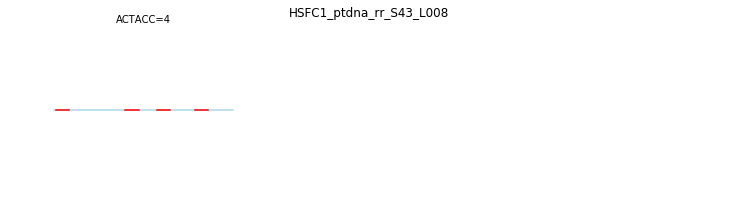

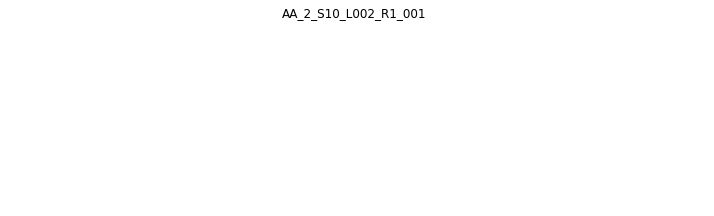

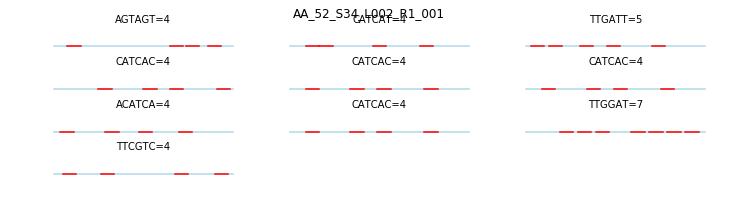

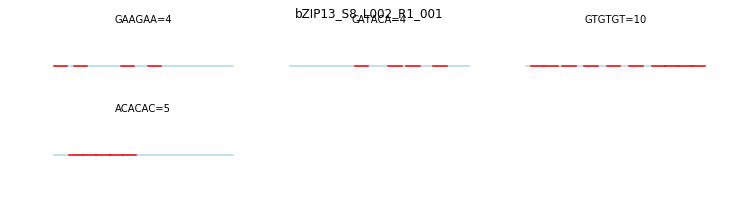

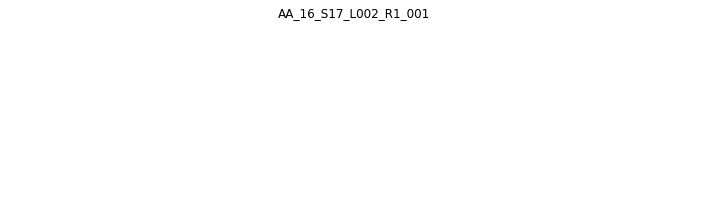

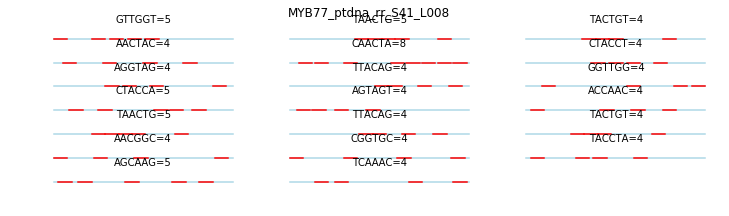

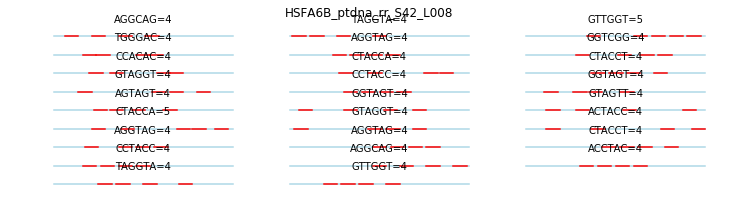

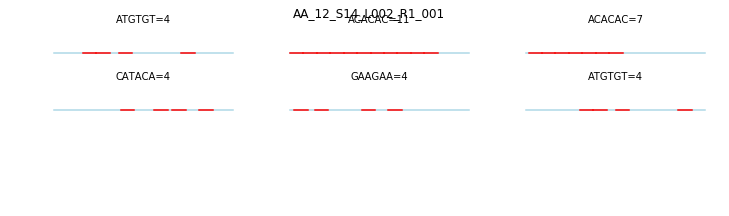

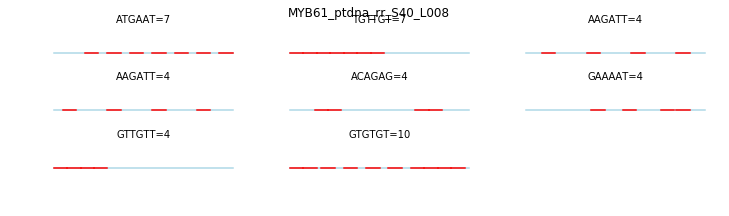

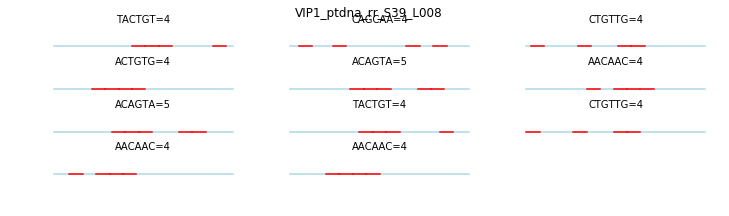

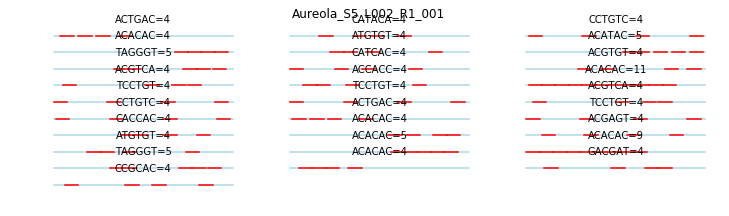

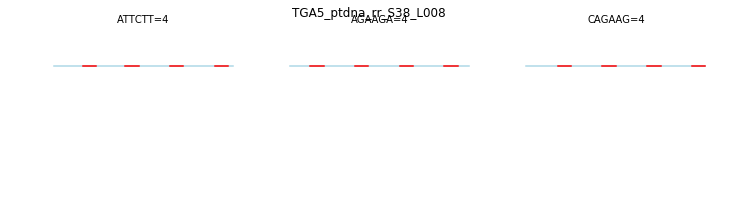

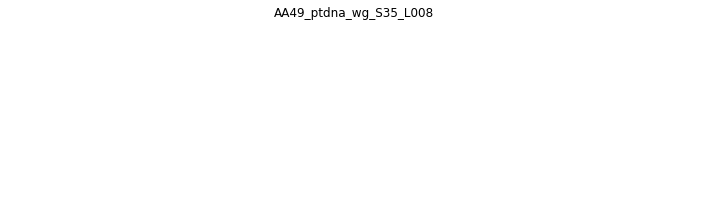

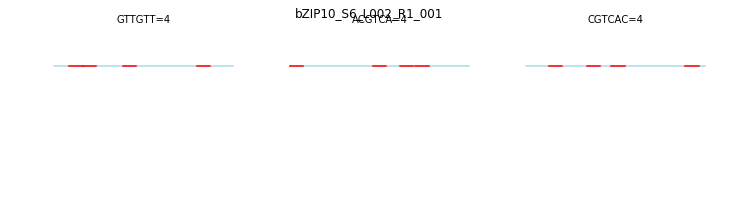

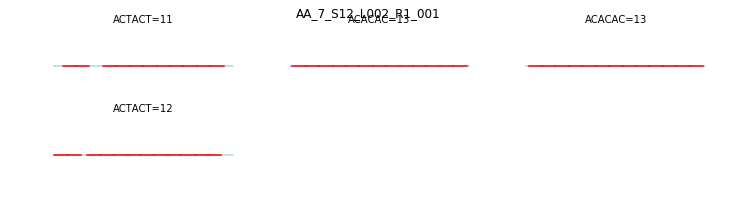

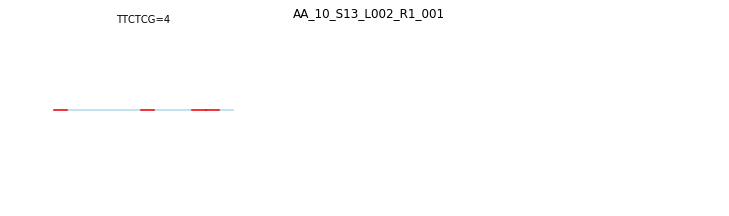

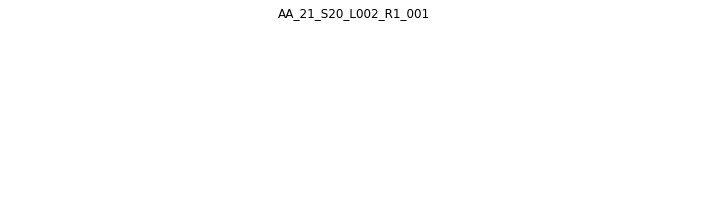

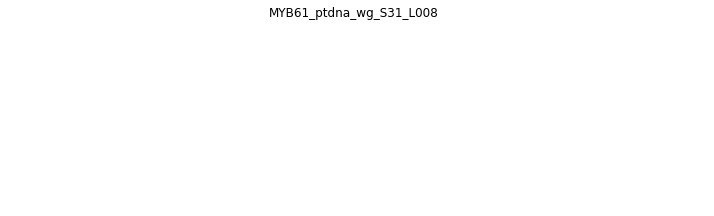

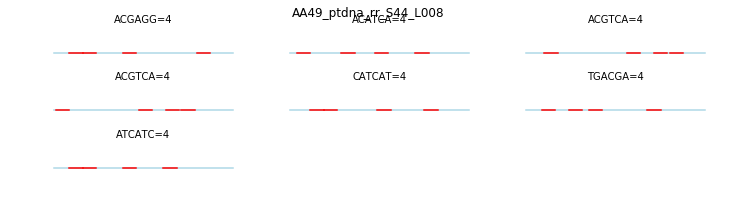

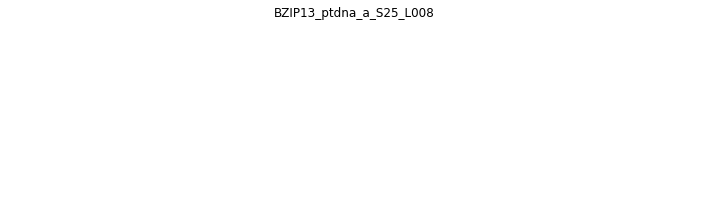

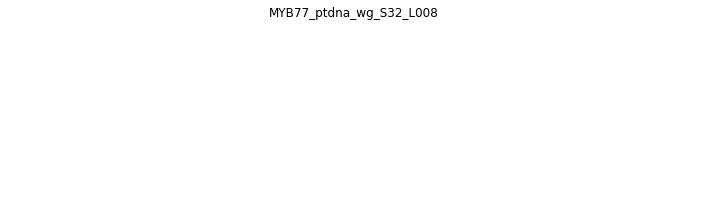

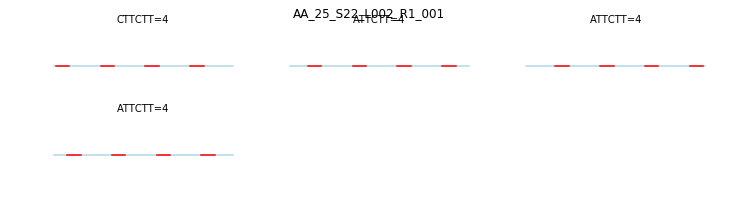

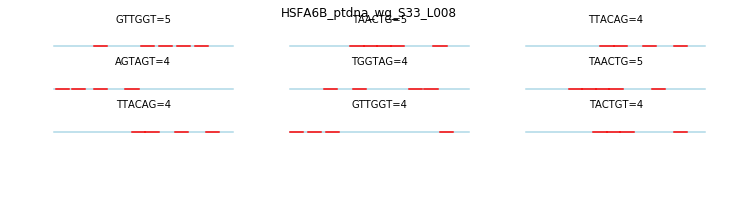

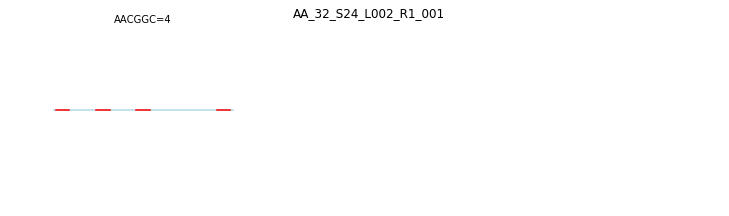

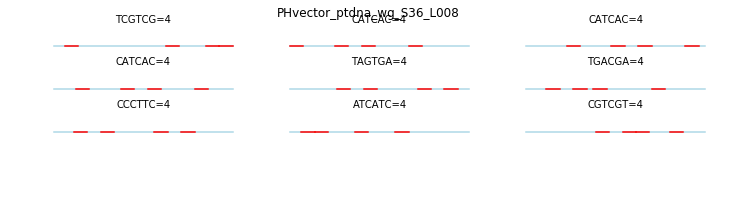

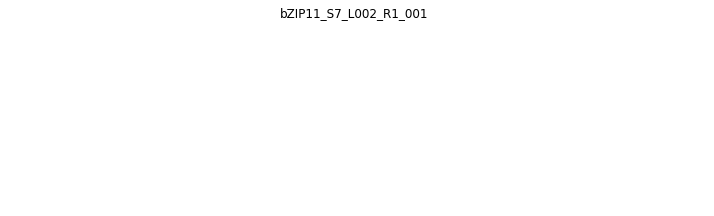

In [22]:
#7.3 Filter out tandem sequences 

# P of 6-mer show up in n base pair
# m time n/(4^6)^m - 1 time 0.12 -2 times 0.3e-3 -3 times 7.3e-9
for count,item in enumerate(Sub_sample_list1):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        print(str(count+1)+'/'+str(len(Sub_sample_list1)),item)
        fasta_file = os.environ['file_path']+'/fasta/'+os.environ['sample_ID']+'.fasta.nodup'
        Tandem_filter(fasta_file,k = 6,k_max = 4)    

In [23]:
#8 Use meme suite to build motif model

'''-objfun ce - This objective function scores motifs based on their enrichment in the central regions of the primary sequences, which must all be of same the length. (See option -cefrac, below.) 
The width and number of sites of each motif are determined using the binomial test. '''
# -mod anr/oops/zoops
# -ws The gap extension cost for creating the alignments used to trim the motif.

for item in Sub_sample_list1:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N MEME.$sample_ID -cwd -e gridout/err -o gridout/out \
        meme $file_path/fasta/$sample_ID.fasta.nodup \
        -nmotifs 1 -minw 4 -maxw 12 -dna -mod oops -nostatus \
        -oc $file_path/GEM_BED/$sample_ID-meme

Your job 9440175 ("MEME.HSFC1_ptdna_rr_S43_L008") has been submitted
Your job 9440176 ("MEME.AA_2_S10_L002_R1_001") has been submitted
Your job 9440177 ("MEME.AA_52_S34_L002_R1_001") has been submitted
Your job 9440178 ("MEME.bZIP13_S8_L002_R1_001") has been submitted
Your job 9440179 ("MEME.AA_16_S17_L002_R1_001") has been submitted
Your job 9440180 ("MEME.MYB77_ptdna_rr_S41_L008") has been submitted
Your job 9440181 ("MEME.HSFA6B_ptdna_rr_S42_L008") has been submitted
Your job 9440182 ("MEME.AA_12_S14_L002_R1_001") has been submitted
Your job 9440183 ("MEME.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9440184 ("MEME.VIP1_ptdna_rr_S39_L008") has been submitted
Your job 9440185 ("MEME.Aureola_S5_L002_R1_001") has been submitted
Your job 9440186 ("MEME.TGA5_ptdna_rr_S38_L008") has been submitted
Your job 9440187 ("MEME.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9440188 ("MEME.bZIP10_S6_L002_R1_001") has been submitted
Your job 9440189 ("MEME.AA_7_S12_L002_R1_001") has

In [24]:
#9 Locate motif loci in the genome
for item in Sub_sample_list1:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N FIMO.$sample_ID -hold_jid MEME.$sample_ID -cwd -e gridout/err -o gridout/out \
        fimo -verbosity 1 --thresh 1e-5\
        -oc $file_path/GEM_BED/$sample_ID-fimo/ \
        $file_path/GEM_BED/$sample_ID-meme/meme.txt \
        ./Genome_REF/PT_Chr_only.fa

Your job 9440201 ("FIMO.HSFC1_ptdna_rr_S43_L008") has been submitted
Your job 9440202 ("FIMO.AA_2_S10_L002_R1_001") has been submitted
Your job 9440203 ("FIMO.AA_52_S34_L002_R1_001") has been submitted
Your job 9440204 ("FIMO.bZIP13_S8_L002_R1_001") has been submitted
Your job 9440205 ("FIMO.AA_16_S17_L002_R1_001") has been submitted
Your job 9440206 ("FIMO.MYB77_ptdna_rr_S41_L008") has been submitted
Your job 9440207 ("FIMO.HSFA6B_ptdna_rr_S42_L008") has been submitted
Your job 9440208 ("FIMO.AA_12_S14_L002_R1_001") has been submitted
Your job 9440209 ("FIMO.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9440210 ("FIMO.VIP1_ptdna_rr_S39_L008") has been submitted
Your job 9440211 ("FIMO.Aureola_S5_L002_R1_001") has been submitted
Your job 9440212 ("FIMO.TGA5_ptdna_rr_S38_L008") has been submitted
Your job 9440213 ("FIMO.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9440214 ("FIMO.bZIP10_S6_L002_R1_001") has been submitted
Your job 9440215 ("FIMO.AA_7_S12_L002_R1_001") has

In [27]:
#9.1 Convert gff to bed
Sub_sample_list2 = [name.split('-')[0] for name in os.listdir(os.environ['file_path']+"/GEM_BED/") if name.endswith('fimo')]

for item in Sub_sample_list2:
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N gff2bed.$sample_ID -hold_jid FIMO.$sample_ID -cwd -e gridout/err \
        -o $file_path/GEM_BED/$sample_ID-fimo/fimo.bed \
        gff2bed -i $file_path/GEM_BED/$sample_ID-fimo/fimo.gff

Your job 9440229 ("gff2bed.AA_52_S34_L002_R1_001") has been submitted
Your job 9440230 ("gff2bed.bZIP10_S6_L002_R1_001") has been submitted
Your job 9440231 ("gff2bed.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9440232 ("gff2bed.AA_32_S24_L002_R1_001") has been submitted
Your job 9440233 ("gff2bed.AA_16_S17_L002_R1_001") has been submitted
Your job 9440234 ("gff2bed.VIP1_ptdna_rr_S39_L008") has been submitted
Your job 9440235 ("gff2bed.HSFA6B_ptdna_wg_S33_L008") has been submitted
Your job 9440236 ("gff2bed.AA_12_S14_L002_R1_001") has been submitted
Your job 9440237 ("gff2bed.bZIP11_S7_L002_R1_001") has been submitted
Your job 9440238 ("gff2bed.AA_10_S13_L002_R1_001") has been submitted
Your job 9440239 ("gff2bed.AA49_ptdna_rr_S44_L008") has been submitted
Your job 9440240 ("gff2bed.AA_7_S12_L002_R1_001") has been submitted
Your job 9440241 ("gff2bed.MYB61_ptdna_wg_S31_L008") has been submitted
Your job 9440242 ("gff2bed.MYB77_ptdna_rr_S41_L008") has been submitted
Your job 94

In [ ]:
#9.2 Compare motif to peaks called by GEM and MACS2

def get_type(x):
    if len(x.split(','))>1:
        return 0
    elif 'MACS' in x:
        return 1
    elif 'GEM' in x:
        return 2
    else:
        return -1
    
venn_set = {}
for item in tqdm(Sub_sample_list2):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        try:
            !bedtools intersect -wa -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.MACS.bed \
            > $file_path/compare_bed/$sample_ID.MACS_peak.bed
            !bedtools intersect -wa -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.GEM.bed \
            > $file_path/compare_bed/$sample_ID.GEM_peak.bed
            !bedtools intersect -wa -a $file_path/compare_bed/$sample_ID.MACS.bed -b $file_path/compare_bed/$sample_ID.GEM.bed \
            > $file_path/compare_bed/$sample_ID.compare_peak.bed
            # !bedtools intersect -wa -a $file_path/GEM_BED/$sample_ID-fimo/fimo.bed -b $file_path/compare_bed/$sample_ID.MACS.bed $file_path/compare_bed/$sample_ID.GEM.bed \
            # > $file_path/compare_bed/$sample_ID.all_peak.bed

            df_MACS = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.MACS.bed',header = None)
            df_GEM = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.GEM.bed',header = None)
            df_Motif = pd.read_table(os.environ['file_path']+'/GEM_BED/'+os.environ['sample_ID']+'-fimo/fimo.bed',header = None) 

            df_compare_MACS_peak = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.MACS_peak.bed',header = None)
            #df_compare_MACS_peak = df_compare_MACS_peak.drop_duplicates(7)
            df_compare_GEM_peak = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.GEM_peak.bed',header = None)
            #df_compare_GEM_peak = df_compare_GEM_peak.drop_duplicates(7)
            df_compare = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.compare_peak.bed',header = None)

            # compare all three 
            df_compare_motif = pd.read_table(os.environ['file_path']+'/compare_bed/'+os.environ['sample_ID']+'.all_peak.bed',header = None)
            df_compare_motif = df_compare_motif.drop_duplicates()
            
            All_overlay = len(set(df_compare_MACS_peak[3]).intersection(df_compare_GEM_peak[3]))
            
            # Unique to MACS
            MACS_only = len(df_MACS)-len(df_compare)-len(df_compare_MACS_peak)+All_overlay
            # Unique to GEM
            GEM_only = len(df_GEM)-len(df_compare)-len(df_compare_GEM_peak)+All_overlay
            # Unique to MOTIF
            MOTIF_only = len(df_Motif) - len(df_compare_MACS_peak) - len(df_compare_GEM_peak) + All_overlay

            # GEM overlap MACS only
            GEM_MACS_only = len(df_compare) - All_overlay
            # MACS overlap MOTIF only
            MACS_MOTIF_only = len(df_compare_MACS_peak) - All_overlay
            # GEM overlap MOTIF only
            GEM_MOTIF_only = len(df_compare_GEM_peak) - All_overlay
            
            # Get the overaly motif and write into bed format
            df_Motif.set_index(3).loc[set(df_compare_MACS_peak[3]).union(df_compare_GEM_peak[3])].reset_index()[[0,1,2,3]].to_csv(os.environ['file_path']+'/Combined_BED/'+os.environ['sample_ID']+'.intersection.bed',header = None, index = False, sep = '\t')
            venn_set[item] = [MACS_only, GEM_only, GEM_MACS_only, MOTIF_only,MACS_MOTIF_only,GEM_MOTIF_only,All_overlay]
        except:
            continue

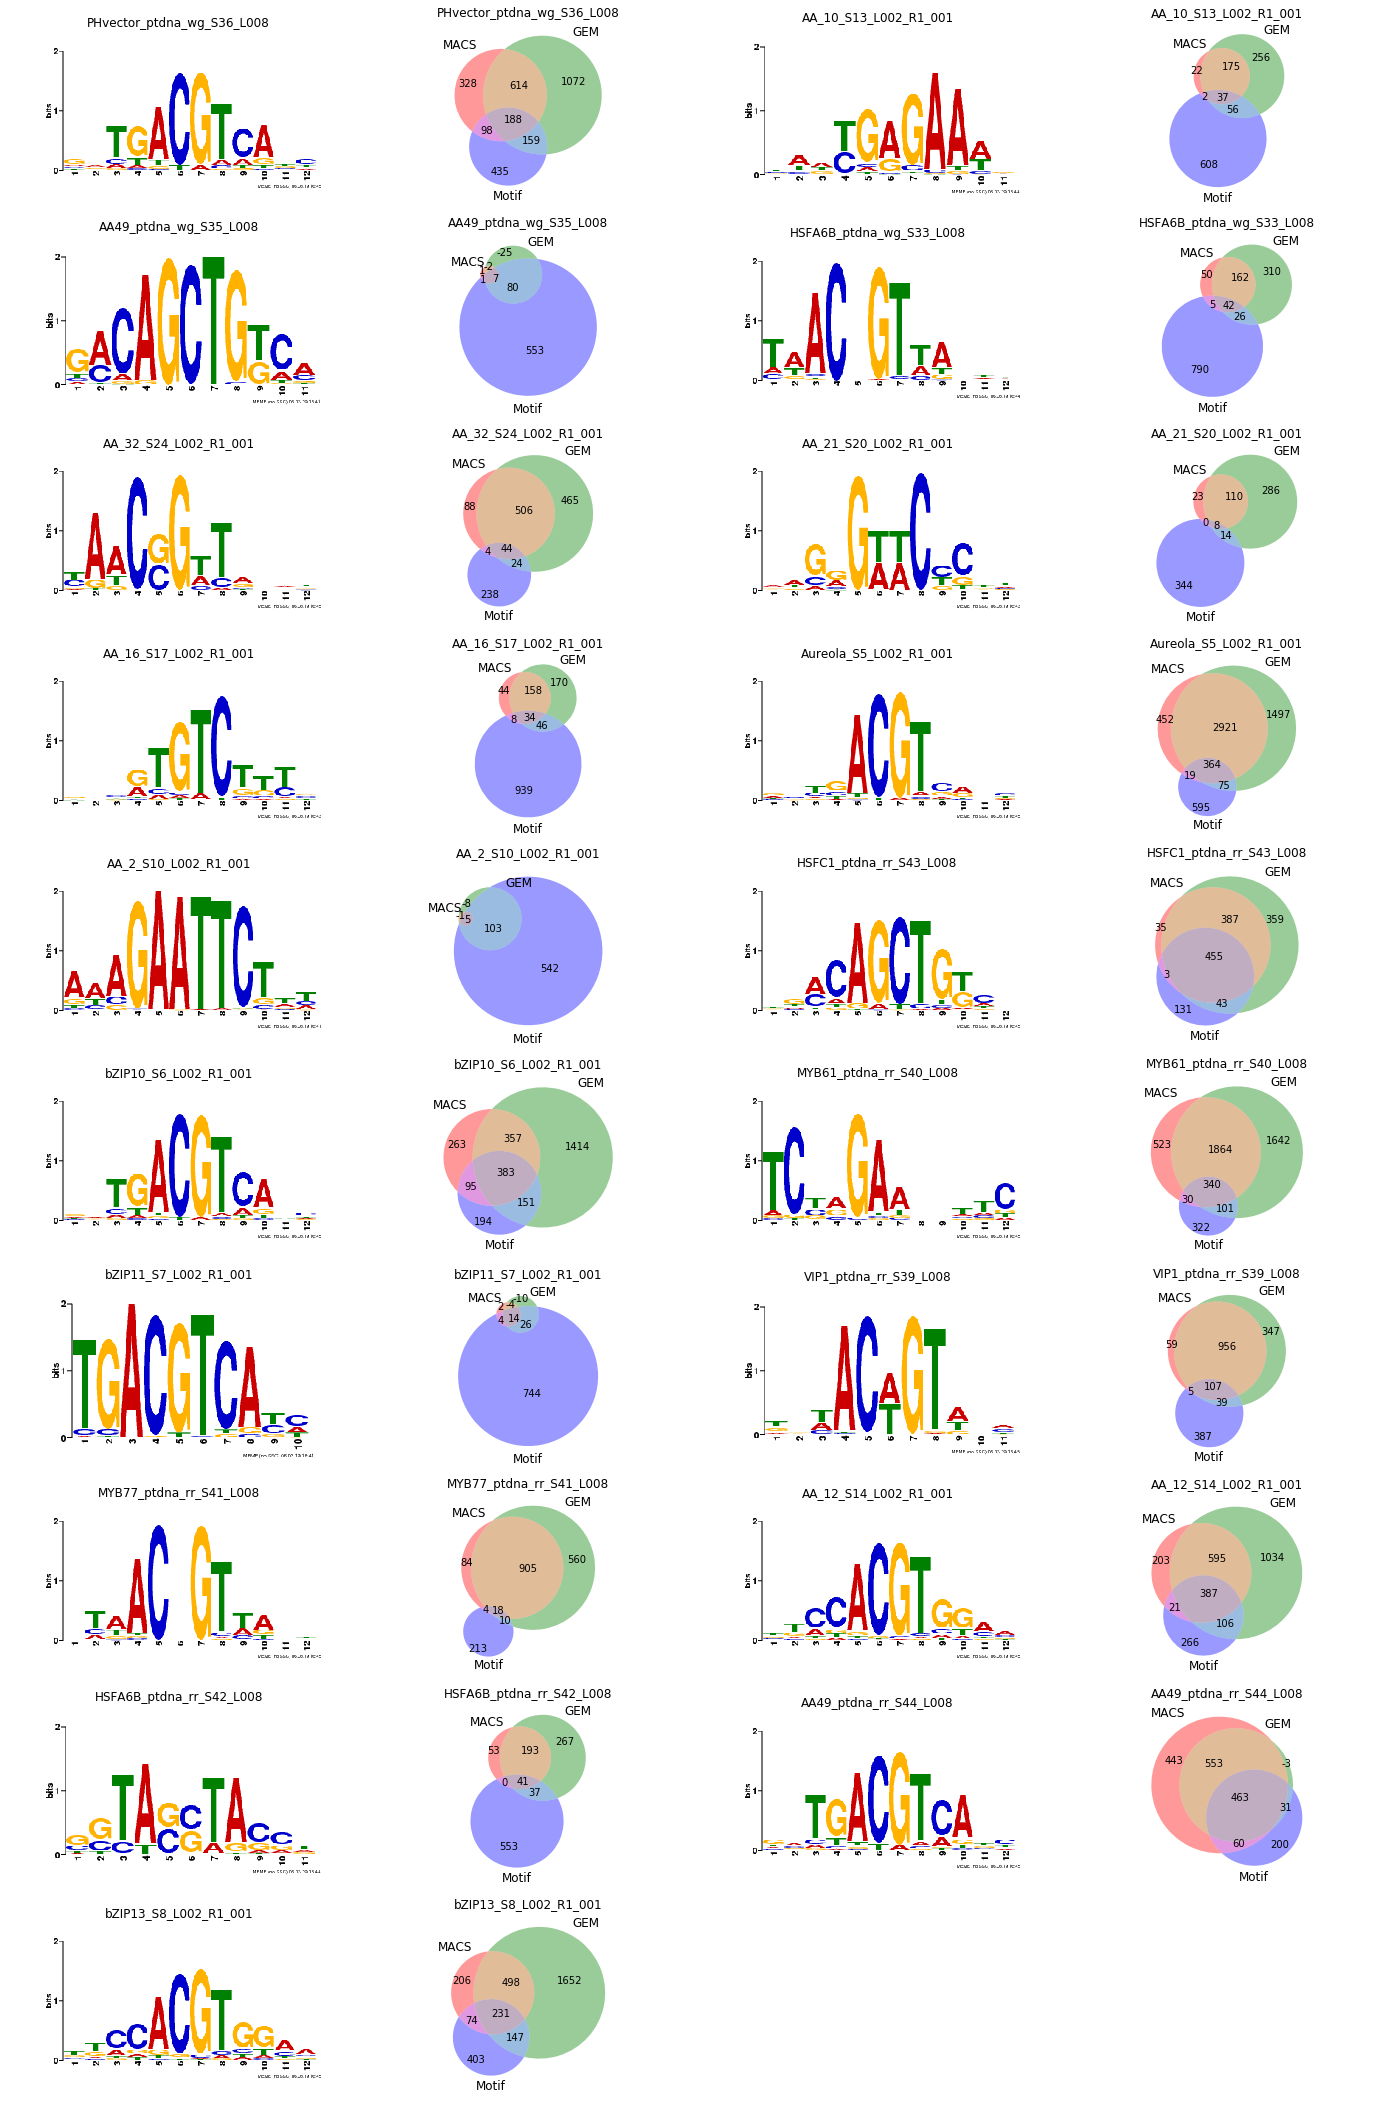

In [148]:
#10 Visulize the final results
%matplotlib inline
f,ax = plt.subplots(2*int(len(venn_set)/4)+2,4,figsize = (24,max(8,len(venn_set)*2)))
ax = ax.ravel()
[axi.set_axis_off() for axi in ax.ravel()]  
for ix,sets in enumerate(venn_set):
    ax[2*ix+1].set_title(str(sets))
    venn3(subsets = (venn_set[sets]),set_labels = ('MACS', 'GEM', 'Motif'),ax = ax[2*ix+1],)
    ax[2*ix].set_title(str(sets))
    img = mpimg.imread(os.environ['file_path']+'/GEM_BED/'+sets+'-meme/logo1.png')
    ax[2*ix].imshow(img);



In [163]:
#11 Find motif that its locaiton overlaps with GEM and MACS targeted peaks

!mkdir -p $file_path/fasta
for item in tqdm(list(venn_set.keys())):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        os.environ['fasta_file'] = os.environ['file_path']+'/fasta/'+os.environ['sample_ID']+'.motif.fasta'
        !bedtools getfasta -fo $fasta_file -fi ./Genome_REF/PT_Chr_only.fa \
        -bed $file_path/Combined_BED/$sample_ID.intersection.bed

100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


In [164]:
#12 Do another round of MEME to build better motif model
for item in list(venn_set.keys()):
    if os.environ['control'] not in item:
        os.environ['sample_ID'] = item
        !qsub -P $project_code -N MEME2.$sample_ID -cwd -e gridout/err -o gridout/out \
        meme $file_path/fasta/$sample_ID.motif.fasta \
        -nmotifs 1 -minw 4 -maxw 12 -dna -mod oops -nostatus \
        -oc $file_path/GEM_BED/$sample_ID-meme-intersection


Your job 9440497 ("MEME2.PHvector_ptdna_wg_S36_L008") has been submitted
Your job 9440498 ("MEME2.AA_10_S13_L002_R1_001") has been submitted
Your job 9440499 ("MEME2.AA49_ptdna_wg_S35_L008") has been submitted
Your job 9440500 ("MEME2.HSFA6B_ptdna_wg_S33_L008") has been submitted
Your job 9440501 ("MEME2.AA_32_S24_L002_R1_001") has been submitted
Your job 9440502 ("MEME2.AA_21_S20_L002_R1_001") has been submitted
Your job 9440503 ("MEME2.AA_16_S17_L002_R1_001") has been submitted
Your job 9440504 ("MEME2.Aureola_S5_L002_R1_001") has been submitted
Your job 9440505 ("MEME2.AA_2_S10_L002_R1_001") has been submitted
Your job 9440506 ("MEME2.HSFC1_ptdna_rr_S43_L008") has been submitted
Your job 9440507 ("MEME2.bZIP10_S6_L002_R1_001") has been submitted
Your job 9440508 ("MEME2.MYB61_ptdna_rr_S40_L008") has been submitted
Your job 9440509 ("MEME2.bZIP11_S7_L002_R1_001") has been submitted
Your job 9440510 ("MEME2.VIP1_ptdna_rr_S39_L008") has been submitted
Your job 9440511 ("MEME2.MYB77_ptd

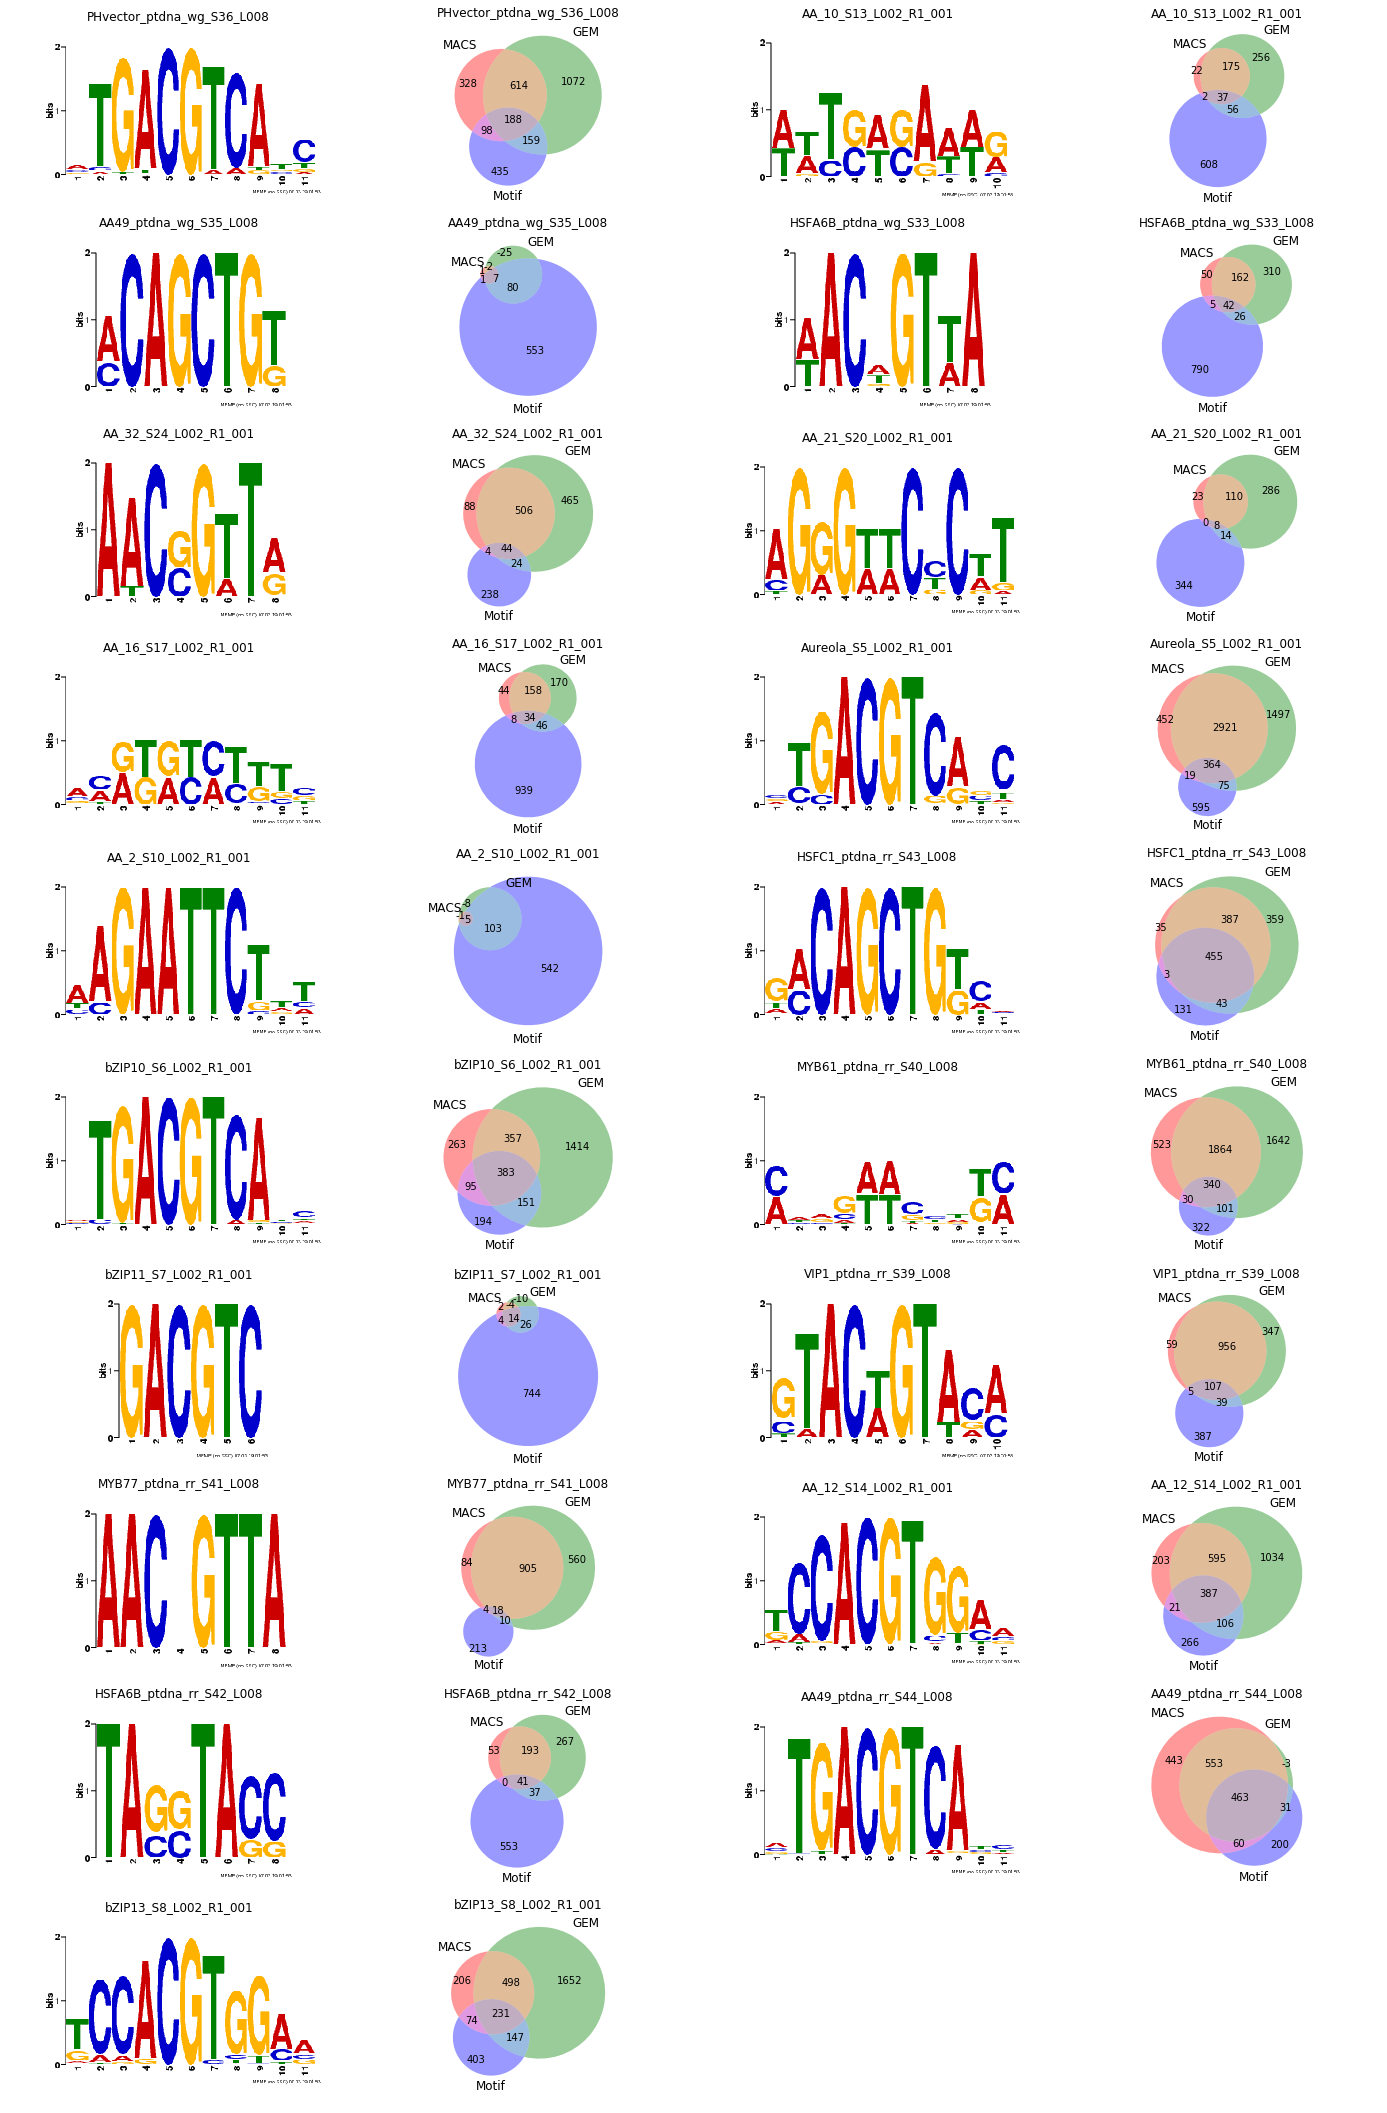

In [167]:
f,ax = plt.subplots(2*int(len(venn_set)/4)+2,4,figsize = (24,max(8,len(venn_set)*2)))
ax = ax.ravel()
[axi.set_axis_off() for axi in ax.ravel()]  
for ix,sets in enumerate(venn_set):
    ax[2*ix+1].set_title(str(sets))
    venn3(subsets = (venn_set[sets]),set_labels = ('MACS', 'GEM', 'Motif'),ax = ax[2*ix+1],)
    ax[2*ix].set_title(str(sets))
    img = mpimg.imread(os.environ['file_path']+'/GEM_BED/'+sets+'-meme-intersection/logo1.png')
    ax[2*ix].imshow(img);

In [184]:
#10 Save all useful output files

!rm big_Wig.zip
!zip -r -q -J -D big_Wig.zip $file_path/GEM_BED/*-fimo/fimo.gff $file_path/bigWig/

rm: cannot remove 'big_Wig.zip': No such file or directory


In [185]:
!rm motif_locaiton.zip
!zip -q -r -D -J motif_locaiton.zip $file_path/Combined_BED/*.intersection.bed

rm: cannot remove 'motif_locaiton.zip': No such file or directory
